In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size = 0.3, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image

train_datagen = ImageDataGenerator(rescale = 1./ 255, #데이터에 제공된 값을 곱함
                                   rotation_range = 20, # 무작위 회전에 대한 도(ㅇ) 단위 범위
                                   width_shift_range = 0.1, #이미지를 수평으로 임의로 이동(전체 너비의 대칭)
                                   height_shift_range = 0.1, #이미지를 수직으로 임의로 이동(전체 높이의 대칭)
                                   zoom_range = 0.05, # 무작위 확대/축소 범위
                                   preprocessing_function=to_grayscale_then_rgb,
                                   horizontal_flip = True, #입력을 수평으로 랜덤하게 뒤집음
                                   fill_mode = 'reflect') #One of {“constant”, “nearest”, “reflect” or “wrap”}, “nearest”가 기본
val_datagen = ImageDataGenerator(rescale=1./ 255)
test_datagen = ImageDataGenerator(rescale=1./ 255)

(35000, 32, 32, 3) (35000, 1)
(15000, 32, 32, 3) (15000, 1)


In [2]:
# 원핫인코딩
from tensorflow.keras.utils import to_categorical

y_train_oh = to_categorical(y_train)
y_val_oh = to_categorical(y_val)
y_test_oh = to_categorical(y_test)

y_train_oh[:5]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [3]:
print(X_train.shape, y_train_oh.shape)
print(X_val.shape, y_val_oh.shape)

(35000, 32, 32, 3) (35000, 10)
(15000, 32, 32, 3) (15000, 10)


In [4]:
train_generator = train_datagen.flow(X_train, y_train_oh, batch_size=64)
val_generator = val_datagen.flow(X_val, y_val_oh, batch_size=64)
test_generator = test_datagen.flow(X_test, y_test_oh, batch_size=64)

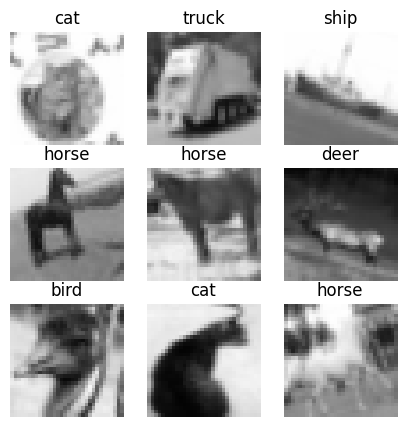

In [5]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
images, labels = next(train_generator)
images[0]
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')

plt.show()


### 데이터로드

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

drop_rate = 0.2

base_model = tf.keras.applications.VGG16(input_shape=(32, 32, 3), include_top=False, weights='imagenet')

def build_cnn_model():
  model = keras.Sequential()
  model.add(base_model)
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(drop_rate))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(drop_rate))
  model.add(layers.Dense(10, activation='softmax'))
  return model

In [7]:
model = build_cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5

In [8]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

In [9]:
EPOCHS = 50
BATCH_SIZE =64

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(train_generator,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data=val_generator,
                    callbacks=[early_stopping])

Epoch 1/50
547/547 [==============================] - 107s 180ms/step - loss: 2.0392 - acc: 0.1955 - val_loss: 1.9133 - val_acc: 0.2256
Epoch 2/50
547/547 [==============================] - 97s 177ms/step - loss: 1.9213 - acc: 0.2471 - val_loss: 1.8799 - val_acc: 0.2614
Epoch 3/50
547/547 [==============================] - 97s 177ms/step - loss: 1.7054 - acc: 0.3319 - val_loss: 1.5360 - val_acc: 0.3955
Epoch 4/50
547/547 [==============================] - 97s 177ms/step - loss: 1.4899 - acc: 0.4308 - val_loss: 1.3883 - val_acc: 0.4849
Epoch 5/50
547/547 [==============================] - 96s 176ms/step - loss: 1.3422 - acc: 0.5136 - val_loss: 1.1846 - val_acc: 0.5787
Epoch 6/50
547/547 [==============================] - 97s 177ms/step - loss: 1.2053 - acc: 0.5767 - val_loss: 1.0216 - val_acc: 0.6475
Epoch 7/50
547/547 [==============================] - 97s 177ms/step - loss: 1.1111 - acc: 0.6186 - val_loss: 0.9824 - val_acc: 0.6673
Epoch 8/50
547/547 [==============================] - 

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize = (10,5))

  plt.subplot(1,2,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
  plt.plot(hist['epoch'], hist['val_loss'], label='Val Loss')
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['acc'], label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_acc'], label='Val Accuracy')
  plt.legend()

plt.show()

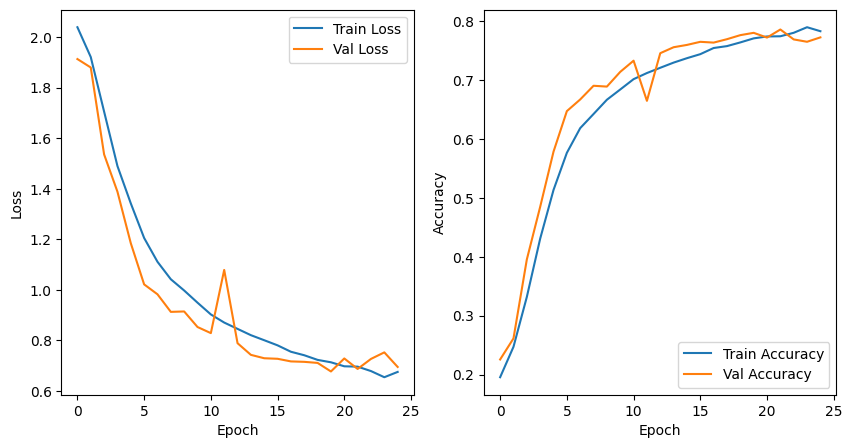

In [14]:
plot_history(history)

In [15]:
y_pred = model.predict(X_test)
y_pred[:1]

313/313 [==============================] - 2s 5ms/step


array([[3.5658030e-22, 2.8665114e-17, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.3412268e-34, 1.0000000e+00]], dtype=float32)

In [16]:
loss, accuracy = model.evaluate(X_test, y_test_oh, verbose=2)
print(f"Test loss: {loss:.2f}")
print(f"Test accuracy: {accuracy:.2f}")


313/313 - 1s - loss: 72.8472 - acc: 0.4341 - 1s/epoch - 5ms/step
Test loss: 72.85
Test accuracy: 0.43


#11. 가장 높은 확률 인덱스 추출
- np.argmax()

In [17]:
y_pred_argmax = np.argmax(y_pred, axis = 1)
y_pred_argmax[:10]


array([9, 0, 8, 0, 1, 0, 1, 9, 9, 1])

#12. 예측 결과의 이미지 표시

<Figure size 1600x600 with 0 Axes>

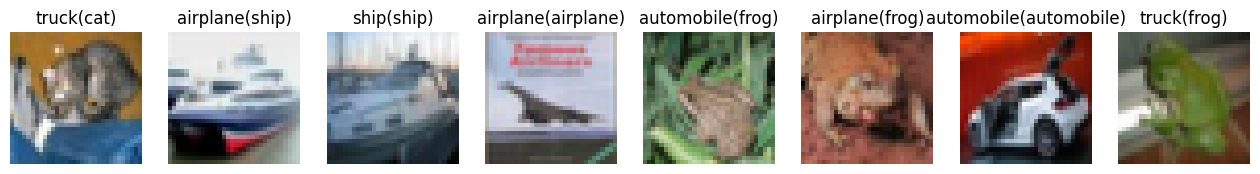

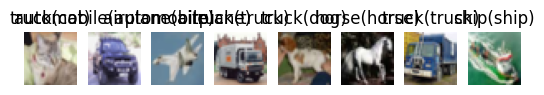

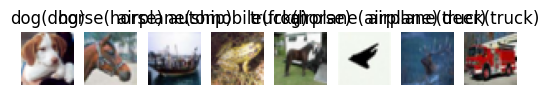

In [18]:
n_rows = 3
n_cols = 8

plt.figure(figsize = (n_cols *2, n_rows *2))
plt.figure(figsize = (n_cols *2, n_rows *2))
for row in range(n_rows):
  for col in range(n_cols):
    index = n_cols * row + col
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(X_test[index], cmap = 'gray')
    #plt.imshow(X_test[index], cmap = 'gray')
    plt.axis('off')
    plt.title(f'{class_names[y_pred_argmax[index]]}({class_names[y_test[index][0]]})')
  plt.show()